In [1]:
import gzip
import json
import statistics
from typing import Iterator

import pandas as pd
from plotnine import *
from surprise import (
    accuracy,
    AlgoBase,
    BaselineOnly,
    Dataset,
    KNNBasic,
    KNNWithZScore,
    NormalPredictor,
    Reader,
    SlopeOne,
    SVD,
)
from surprise.model_selection import cross_validate, train_test_split

# Table of Contents

- [Step B.1](#Step-B.1)
- [Step B.2](#Step-B.2)
- [Step B.3](#Step-B.3)
- [Step B.4](#Step-B.4)

In [2]:
# download the “small” 5-core dataset for the category "Digital Music"
# dataset source: https://nijianmo.github.io/amazon/index.html

!wget --backups=1 http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz -P data/

--2022-02-20 16:22:26--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19408584 (19M) [application/octet-stream]
Saving to: ‘data/Digital_Music_5.json.gz’

Digital_Music_5.jso 100%[===================>]  18.51M   818KB/s    in 53s     

2022-02-20 16:23:20 (356 KB/s) - ‘data/Digital_Music_5.json.gz’ saved [19408584/19408584]



## Step B.1

In [3]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [4]:
def parse(filepath: str) -> Iterator[dict]:
    file_obj = gzip.open(filepath, "rb")
    for line in file_obj:
        yield json.loads(line)

In [5]:
def file_to_dataframe(filepath: str) -> pd.DataFrame:
    i = 0
    df = {}
    for d in parse(filepath):
        df[i] = {
            "user": d["reviewerID"],
            "item": d["asin"],
            "rating": d["overall"],
        }  # keep only the essential data
        i += 1
    return pd.DataFrame.from_dict(df, orient="index")

In [6]:
review_data = file_to_dataframe("data/Digital_Music_5.json.gz")

In [7]:
reader = Reader(rating_scale=(1, 5))

In [8]:
data = Dataset.load_from_df(review_data[["user", "item", "rating"]], reader)

inspect_df(data.df, 10)

shape: (169781, 3)


,user,item,rating
0,A2TYZ821XXK2YZ,3426958910,5.0
1,A3OFSREZADFUDY,3426958910,5.0
2,A2VAMODP8M77NG,3426958910,5.0
3,AAKSLZ9IDTEH0,3426958910,4.0
4,A3OH43OZJLKI09,5557706259,5.0
5,A6JP9YYJCK3WO,5557706259,4.0
6,A20Z0JD766DPG6,5557706259,5.0
7,AXQ89O6YRT7AX,5557706259,5.0
8,A1M379MK8MKGUF,5557706259,5.0
9,AA762OWLWCPQ2,5557706259,5.0


## Step B.2

In [9]:
cv_results = {}

In [10]:
"""
Algorithm predicting a random rating based on the distribution of the training set, 
which is assumed to be normal.
"""
cv_results["NormalPredictor"] = cross_validate(
    algo=NormalPredictor(), data=data, verbose=True, cv=5
)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8916  0.8944  0.8910  0.8894  0.8956  0.8924  0.0023  
MAE (testset)     0.5912  0.5924  0.5928  0.5911  0.5913  0.5918  0.0007  
Fit time          0.15    0.18    0.17    0.18    0.19    0.17    0.01    
Test time         0.27    0.14    0.15    0.14    0.14    0.17    0.05    


In [11]:
"""
Algorithm predicting the baseline estimate for given user and item.
"""
cv_results["BaselineOnly"] = cross_validate(
    algo=BaselineOnly(), data=data, verbose=True, cv=5
)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5979  0.5906  0.6034  0.5827  0.5815  0.5912  0.0085  
MAE (testset)     0.3737  0.3697  0.3739  0.3671  0.3668  0.3703  0.0031  
Fit time          0.38    0.37    0.44    0.47    0.50    0.43    0.05    
Test time         0.08    0.08    0.09    0.19    0.18    0.13    0.05    


In [12]:
"""
A basic item-item collaborative filtering algorithm.
"""
cv_results["KNNBasic (cosine) item-based"] = cross_validate(
    algo=KNNBasic(
        sim_options={
            "name": "cosine",
            "user_based": False,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6028  0.6143  0.6100  0.6195  0.6159  0.6125  0.0057  
MAE (testset)     0.3122  0.3151  0.3129  0.3194  0.3147  0.3149  0.0025  
Fit time          4.51    4.66    4.79    4.52    4.55    4.61    0.10    
Test time         0.69    0.55    0.63    0.64    0.68    0.64    0.05    


In [13]:
"""
A simple yet accurate item-based collaborative filtering algorithm.

This is a straightforward implementation of the SlopeOne algorithm: https://arxiv.org/abs/cs/0702144
"""
cv_results["SlopeOne"] = cross_validate(
    algo=SlopeOne(),
    data=data,
    verbose=True,
    cv=5,
)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5809  0.5752  0.5875  0.5889  0.5791  0.5823  0.0051  
MAE (testset)     0.2719  0.2703  0.2743  0.2765  0.2707  0.2727  0.0023  
Fit time          2.86    2.80    2.81    2.77    2.61    2.77    0.09    
Test time         0.44    0.48    0.47    0.48    0.55    0.49    0.04    


In [14]:
"""
A basic user-user collaborative filtering algorithm.
"""
cv_results["KNNBasic (cosine) user-based"] = cross_validate(
    algo=KNNBasic(
        sim_options={
            "name": "cosine",
            "user_based": True,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7629  0.7728  0.7724  0.7738  0.7590  0.7682  0.0060  
MAE (testset)     0.4621  0.4655  0.4655  0.4672  0.4621  0.4645  0.0020  
Fit time          8.85    9.38    8.92    8.86    8.23    8.85    0.36    
Test time         0.98    0.98    1.04    0.83    0.80    0.92    0.09    


In [15]:
"""
A basic collaborative filtering algorithm, taking into account
the z-score normalization of each user.
"""
cv_results["KNNWithZScore (MSD) user-based"] = cross_validate(
    algo=KNNWithZScore(
        sim_options={
            "name": "msd",
            "user_based": True,
        }
    ),
    data=data,
    verbose=True,
    cv=5,
)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5832  0.5795  0.5863  0.5812  0.5850  0.5830  0.0025  
MAE (testset)     0.2899  0.2904  0.2879  0.2871  0.2919  0.2894  0.0017  
Fit time          5.68    5.39    5.38    5.54    5.53    5.50    0.11    
Test time         0.83    0.85    0.84    0.91    0.84    0.85    0.03    


In [16]:
"""
The famous SVD algorithm, as popularized by `Simon Funk
<http://sifter.org/~simon/journal/20061211.html>`_ during the Netflix Prize.
"""
cv_results["SVD"] = cross_validate(algo=SVD(), data=data, verbose=True, cv=5)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5607  0.5624  0.5690  0.5561  0.5597  0.5616  0.0042  
MAE (testset)     0.3354  0.3352  0.3397  0.3336  0.3341  0.3356  0.0022  
Fit time          5.60    5.20    5.20    5.54    5.71    5.45    0.21    
Test time         0.23    0.21    0.21    0.24    0.16    0.21    0.03    


## Step B.3

In [17]:
df = pd.DataFrame(cv_results).T.reset_index()

df["mean RMSE"] = df["test_rmse"].map(lambda x: statistics.mean(x))

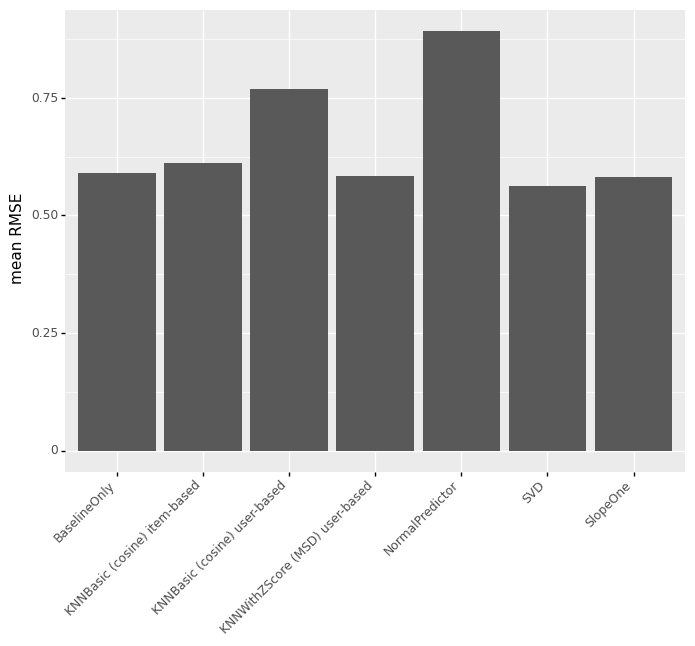

<ggplot: (8727545617387)>

In [18]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE")
)

## Step B.4

In [19]:
trainset, testset = train_test_split(data, test_size=0.25)

In [20]:
recsys = SVD().fit(trainset)

In [21]:
def get_recommendations_for_user(user: str, rs: AlgoBase, n: int = 5) -> list:

    # get n random unseen products for this user
    unseen_items = review_data[review_data["user"] != user]["item"].sample(n).tolist()

    # recommend
    return [rs.predict(uid=user, iid=item) for item in unseen_items]

In [22]:
users = list(set((u for u, _, _ in testset)))

for user in users[:5]:  # show recommendations for first 5 users, no need to display all
    for recommendation in get_recommendations_for_user(user, rs=recsys, n=5):
        print(recommendation)
    print("=" * 105)

user: A35JCASWZL0XBH item: B00HFWYCAK r_ui = None   est = 4.66   {'was_impossible': False}
user: A35JCASWZL0XBH item: B00HRN141C r_ui = None   est = 4.70   {'was_impossible': False}
user: A35JCASWZL0XBH item: B0098TPQ9O r_ui = None   est = 4.95   {'was_impossible': False}
user: A35JCASWZL0XBH item: B00I164EUC r_ui = None   est = 5.00   {'was_impossible': False}
user: A35JCASWZL0XBH item: B00123G5ZI r_ui = None   est = 4.84   {'was_impossible': False}
user: AWS3ZNOPCH244 item: B0013803HS r_ui = None   est = 4.54   {'was_impossible': False}
user: AWS3ZNOPCH244 item: B013HLHZQA r_ui = None   est = 4.69   {'was_impossible': False}
user: AWS3ZNOPCH244 item: B0065Y2H3I r_ui = None   est = 4.79   {'was_impossible': False}
user: AWS3ZNOPCH244 item: B001J1C2ZA r_ui = None   est = 4.70   {'was_impossible': False}
user: AWS3ZNOPCH244 item: B00LAP3KS8 r_ui = None   est = 4.81   {'was_impossible': False}
user: AOIQXY51I12F1 item: B0057PSUZA r_ui = None   est = 4.71   {'was_impossible': False}
user: